# Data620 Project2

## By:  A. Hajjam && M. Chacko

## Introduction

### DESCRIPTION
One 870×557 two mode valued matrix of individuals by involvement in crime events. 
One 870×1 vector displaying the sex of each individual.

### BACKGROUND
In the 1990s Rick Rosenfeld and Norm White used police records to collect data on crime in St. Louis. 
They began with five homicides and recorded the names of all the individuals who had been involved as victims, suspects or witnesses. 
They then explored the files and recorded all the other crimes in which those same individuals appeared. 
This snowball process was continued until they had data on 557 crime events. 
Those events involved 870 participants of which: 569 appeared as victims 682 appeared as suspects 195 appeared as witnesses, and 41 were dual (they were recorded both as victims and suspects in the same crime. 
Their data appear, then, as an 870 by 557, individual by crime event matrix. Victims are coded as 1, suspects as 2, witnesses as 3 and duals as 4.
In addition Rosenfeld and White recorded the sex of each individual.

All data was found here: http://konect.uni-koblenz.de/networks/moreno_crime

Documentation found here: http://moreno.ss.uci.edu/data.html#crime

In [1]:
import pandas as pd
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import networkx.algorithms.bipartite as bp

In [2]:
data_role = "monero_crime_person_role.csv"
data =pd.read_csv(data_role, header=None)
uniqueRoles = set(list(data[0]))
uniqueRoles

{'Suspect', 'Victim', 'Victim Suspect', 'Witness'}

In [3]:
data_crime ="out.moreno_crime_crime"
#data_role = "monero_crime_person_role.csv"
crime = pd.read_csv(data_crime, delim_whitespace=True, header=None, skiprows=[0,1], names=['Person', 'Crime'])
crime['Rel_Role'] = pd.read_csv(data_role, header=None)
crime.head()

,Person,Crime,Rel_Role
0,1,1,Suspect
1,1,2,Victim
2,1,3,Victim
3,1,4,Suspect
4,2,5,Victim


In [4]:

crime.count()

Person      1476
Crime       1476
Rel_Role    1476
dtype: int64

In [5]:
len(set(crime.Person))

829

In [6]:
len(set(crime.Crime))

551

In [7]:
# checking relationship Roles 
Relations = crime.groupby('Rel_Role')
Relations.count()

#Relations.count().iloc[:,0]

,Person,Crime
Rel_Role,,
Suspect,682,682
Victim,558,558
Victim Suspect,41,41
Witness,195,195


#Crimes By Person
crimes_per_person = crime.groupby('Person')
crimes_per_person.count()[:, 1]

## Crime Distribution (by Person)

##### Accordong to the graph below, most Persons were involved in a single crime.


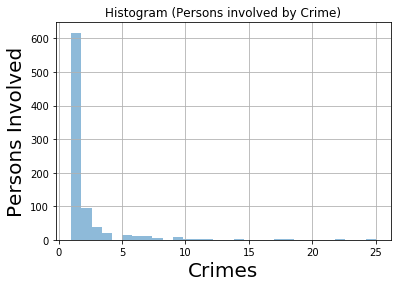

In [8]:

# histogram [count of Crimes]
crime_count = pd.DataFrame({'Crime_Count' : crime.groupby(['Person']).size()}).reset_index()
crime_count.iloc[:,1].plot.hist(alpha=0.5, bins=30)
plt.xlabel('Crimes', fontsize=20)
plt.ylabel('Persons Involved', fontsize=20)
plt.title('Histogram (Persons involved by Crime)')
plt.grid(True)
plt.rcParams['figure.figsize'] = (25, 10)
plt.show()

#### For every person, let's see how many crimes he/she was involved in, and how many Roles he/she had. We'll add the count information to every row, for quick access.

In [9]:
extended_crime = crime
#how many Crimes
extended_crime['num_crimes'] = extended_crime.groupby(['Person'])['Crime'].transform('count')

#how many Roles
extended_crime['num_rel_role'] = extended_crime.groupby(['Person', 'Rel_Role'])['Crime'].transform('count')

extended_crime.head()

,Person,Crime,Rel_Role,num_crimes,num_rel_role
0,1,1,Suspect,4,2
1,1,2,Victim,4,2
2,1,3,Victim,4,2
3,1,4,Suspect,4,2
4,2,5,Victim,22,4


#### let's make the records meaningful by adding corresponding person name and sex, since do have data for that. 


In [10]:
#get name data
data_name = 'ent.moreno_crime_crime.person.name'
names = pd.read_csv(data_name, sep='\t', header=None)

#get sex data
data_sex = 'ent.moreno_crime_crime.person.sex'
names['Sex'] = pd.read_csv(data_sex, header=None)

names.ix[names.Sex == 1, 'Sex'] = 'M'
names.ix[names.Sex == 0, 'Sex'] = 'F'


c:\Users\moc9029\Anaconda\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
c:\Users\moc9029\Anaconda\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


In [11]:
extended_crime["Sex"] = ""
# replacing left nodes (people involved in a crime) with names and adding sex
# Right nodes stay as numbers to identify as crimes, not people
for i in range(0,len(names)):
    extended_crime.ix[extended_crime.Person == i+1, 'Sex'] = names.iloc[i]["Sex"]
    extended_crime.ix[extended_crime.Person == i+1, 'Person'] = names.iloc[i][0]
    
extended_crime.head()

c:\Users\moc9029\Anaconda\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
c:\Users\moc9029\Anaconda\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,Person,Crime,Rel_Role,num_crimes,num_rel_role,Sex
0,AbelDennis,1,Suspect,4,2,M
1,AbelDennis,2,Victim,4,2,M
2,AbelDennis,3,Victim,4,2,M
3,AbelDennis,4,Suspect,4,2,M
4,AbramsChad,5,Victim,22,4,M


## Relationship Roles

#### There are lot of overlaps. Many suspects are also victims, and many Victimes are also witnesses. The other way is also true.
#### For example Katz who is a criminal Pro, has been involved in 18 crimes, 2 victims, once as a witness and 15 times as a suspect.

In [12]:
## Grouping suspect, victim and witness nodes in groups, and compute the overlap
suspects = set(extended_crime[extended_crime['Rel_Role'] == "Suspect"].iloc[:, 0].unique())
victims = set(extended_crime[extended_crime['Rel_Role'] == 'Victim'].iloc[:,0].unique())
witness = set(extended_crime[extended_crime['Rel_Role'] == "Witness"].iloc[:, 0].unique())

sus_len = len(suspects)
vict_len = len(victims)
wit_len = len(witness)

sus_vict = len(suspects.intersection(victims))
sus_wit = len(suspects.intersection(witness))
vict_wit = len(victims.intersection(witness))

print('') 
print('Suspect | Victim | Witness Overlap')
print ('----------------------------------')
print ('')
print ('Suspects:               ', sus_len)
print ('Victims:                ', vict_len)
print ('Witnesses:              ', wit_len)
print ('')
print ('Suspect and Victim:      ', sus_vict)
print ('Suspect and Witness:     ', sus_wit)
print ('Victim and Witness:      ', vict_wit)
print ('Victim and Witness:      ', vict_wit)


Suspect | Victim | Witness Overlap
----------------------------------

Suspects:                412
Victims:                 369
Witnesses:               189

Suspect and Victim:       94
Suspect and Witness:      41
Victim and Witness:       52
Victim and Witness:       52


## Bipartite Graph


In [13]:
## reloading data in bipartite fashion
G2 = nx.Graph()
# adding Person nodes
for i in range(len(extended_crime)): 
    G2.add_node(extended_crime.iloc[i][0],
                Relation=extended_crime.iloc[i][2],
                rel_count=extended_crime.iloc[i][3],
                weight=extended_crime.iloc[i][4],
                Sex=extended_crime.iloc[i][5],
                bipartite=1)


In [14]:
# add crime nodes
for i in range(len(extended_crime)): 
    G2.add_node(extended_crime.iloc[i][1],
                bipartite=0)

In [15]:
# add edges
# There's an edge between two stations if there was a trip between them.
# Edges are weighted by the number of trips
for i in range(len(extended_crime)):
    G2.add_edge(extended_crime.iloc[i][0], extended_crime.iloc[i][1], weight=1)

In [16]:
# is this graph connected. 
nx.is_connected(G2)

False

In [17]:
#Is it bipartite
nx.is_bipartite(G2)

True

In [18]:
# Generaing a list of top_nodes(people) and bottom_nodes(crime)
top_nodes = set(n for n,d in G2.nodes(data=True) if d['bipartite']==1)
bottom_nodes = set(G2) - top_nodes

## Examine this!!!

In [19]:
#get the info about our graph
print(nx.info(G2))

Name: 
Type: Graph
Number of nodes: 1380
Number of edges: 1476
Average degree:   2.1391


In [20]:
# Printing the first 15 individuals in the dataset
print ("First 15 Persons:")

for i in range(10):
    print (' %s    ' % (list(top_nodes)[i]))

First 15 Persons:
 HolmesMort    
 BeckerToby    
 HallNorman    
 CasperSheila    
 ShawMable    
 SteeleKurt    
 PitneyRoy    
 MailerMary    
 PowellCyndi    
 HamiltonTerrance    


## Graph this bipartite


C:\Users\moc9029\AppData\Roaming\Python\Python37\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


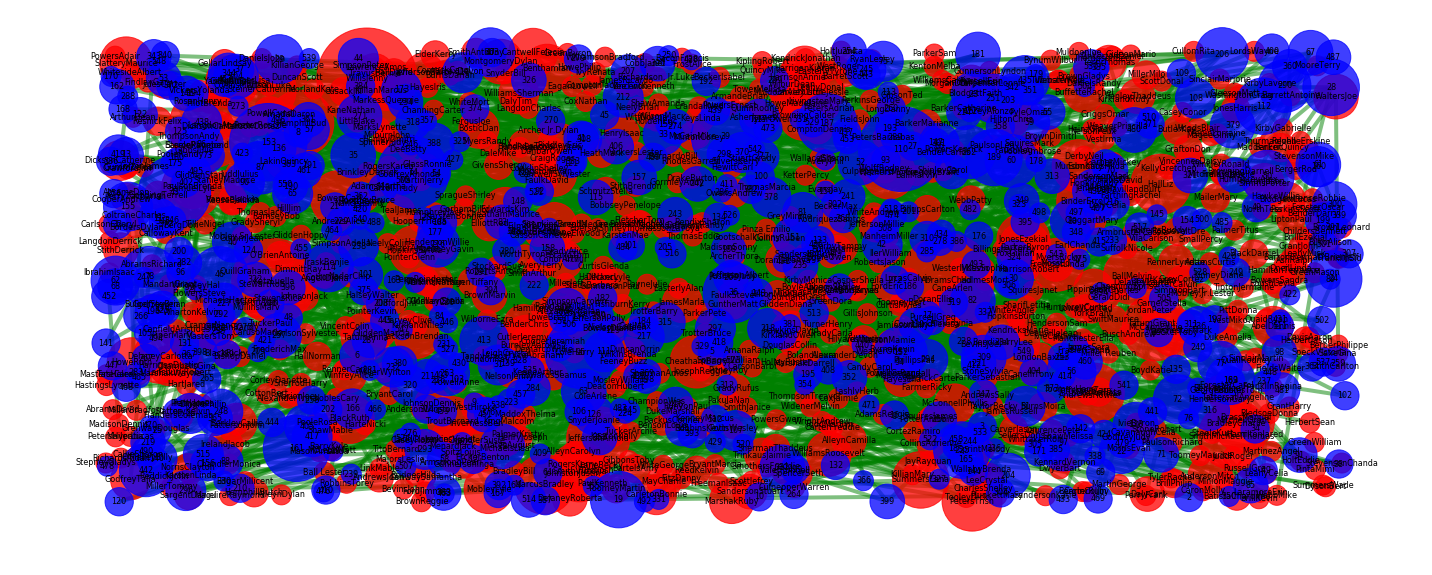

In [21]:
# ## plot the overall network
pos=nx.random_layout(G2) # positions for all nodes

# ## elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['Count'] > 10]
# ## esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['Count'] <= 10]

colors=[]
for n in dict(G2.degree()).keys():    
    if n in dict(G2.degree(top_nodes)).keys():
        colors.append('r')
    else:
        colors.append('b')

# # nodes
d = G2.degree()
nx.draw_networkx_nodes(G2,pos, node_color=colors, node_size=[v*400 for v in dict(d).values()], alpha=0.75)

# edges
nx.draw_networkx_edges(G2,pos, width=4,alpha=0.5,edge_color='g',style='solid')
#nx.draw_networkx_edges(G2,pos,edgelist=esmall, width=2,alpha=0.2,edge_color='b',style='dashed')

# labels
nx.draw_networkx_labels(G2, pos, font_size=8, font_family='sans-serif')

plt.axis('off')
plt.show()

## Person - Bipartite Projection

#### 1. Island Method and analysis 

We will use the island method after the creation of the weighted bipartite graph. Weights are the number of shared neighbors for an edge. First we isolate the biggest component of the bipartite graph, then we apply the island method and print the threshold level, the size of the graph, and the number of connected components.

In [22]:
## SNAFS: get a sorted degree list to obtain topmost nodes
def sorted_map(map):
    ms = sorted(map.iteritems(), reversed = True) #key=lambda (k,v) : (-v, k))
    return ms

## Implementing the Island Method to look for important subgroups. ##
def trim_edges(g, weight = 1):
    # Implements a trimming of the graph edges for the Island Analysis
    g2 = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to)
    return g2

def island_method(g, iterations = 5):
    # Iterates through the graph removing edges and returning the number of edges removed and
    #  the trimmed graph
    weights = [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    step = int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx)]

#### 2. Island method results

A threshold value of 2 results in a network of 28 Persons and 12 connected components. Of particular interest are suspect nodes connected to Luella Katz, the most-connected suspect in the graph with a degree centrality of 51. Katz is also connected to two other high-degree suspects, Michael Thomas Smith (33 degrees) and Catherine Steiner (29). Both are in the top 10 list of suspects by degree centrality.

In [23]:
PC = nx.bipartite.weighted_projected_graph(G2, top_nodes)
cc = list(nx.connected_component_subgraphs(PC))[0]
print(cc)

In [24]:
## Running the Island Analysis on the graph. Will throw an error if the island_method is called with too many steps
islands = island_method(cc,3)
print ('')
print ('Threshold |  Size (Persons)  |  Connected Components')
print ('******************************************************')
for island in islands:
    print('   %d               %2d                   %2d' 
          %(island[0], len(island[1]), len(list(nx.connected_component_subgraphs(island[1]))))) 


Threshold |  Size (Persons)  |  Connected Components
******************************************************
   1               89                   27
   2               28                   12
   3               15                    7
   4                6                    3


#### 3. Graph this at a treshhold = 2.

C:\Users\moc9029\AppData\Roaming\Python\Python37\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


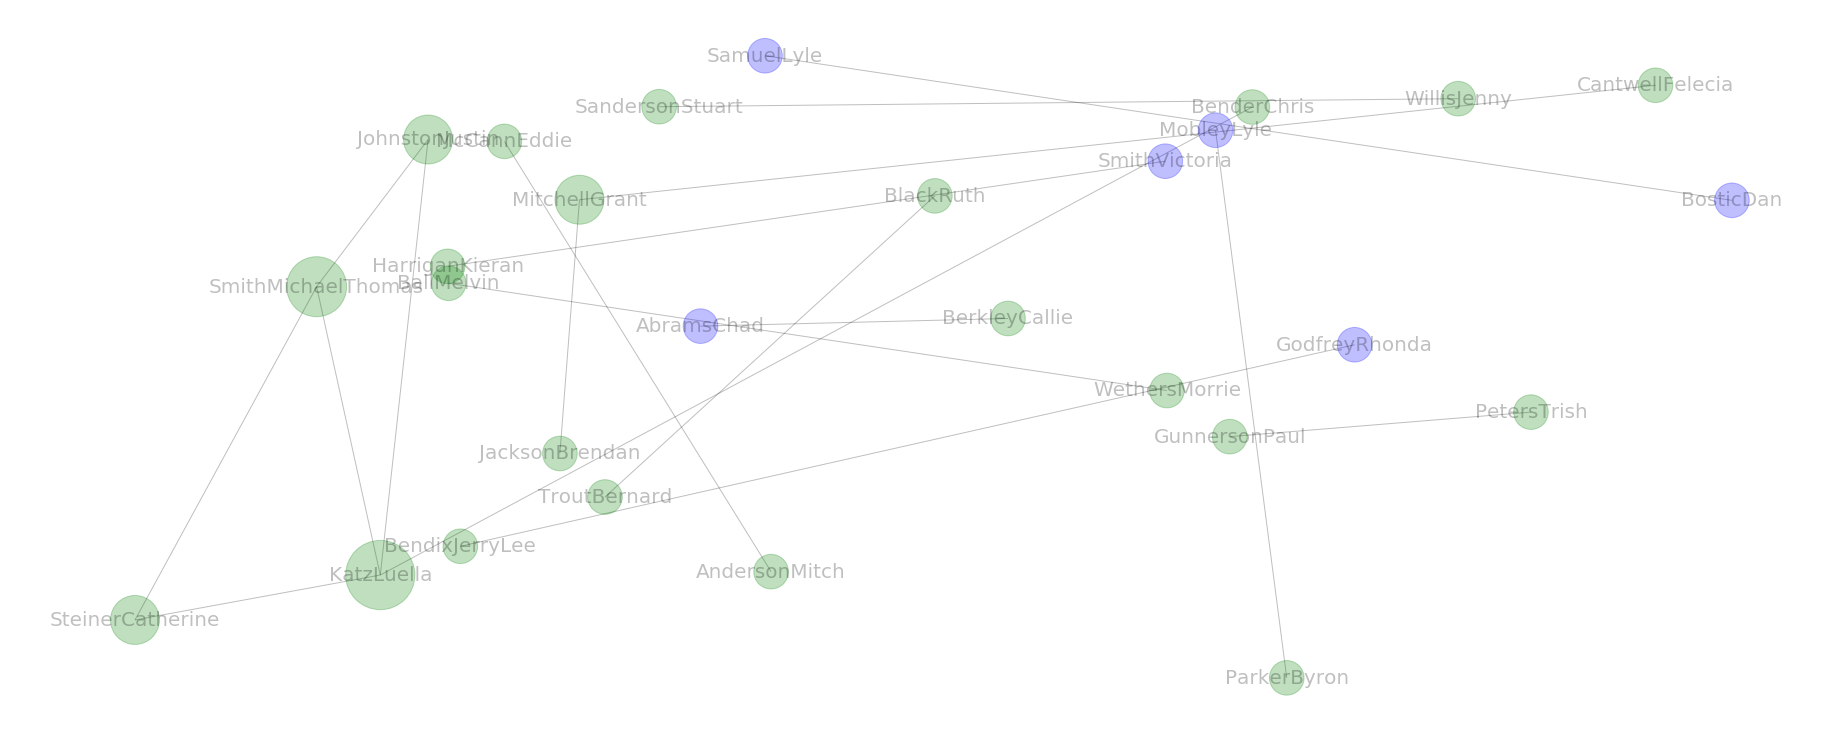

In [25]:
## Plot created by the island analysis
pc = trim_edges(cc, 2)

nodecolors=[]
for n in dict(pc.degree(top_nodes)).keys():
    if n in suspects:
        nodecolors.append('g')
    elif n in victims:
        nodecolors.append('b')
    else:
        nodecolors.append('y')

dpc = pc.degree()
nx.draw_random(pc, node_size=[v*1200 for v in dict(dpc).values()], with_labels=True, node_color=nodecolors, 
               alpha=.25, font_size=20)

## 4. What about the person Katz. Let's give him a visit and check his ego network.

#### Katz has 51 connections to other people. Those persons are themselves involved as suspects in 40 crimes and victimes in 22 crimes.

C:\Users\moc9029\AppData\Roaming\Python\Python37\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


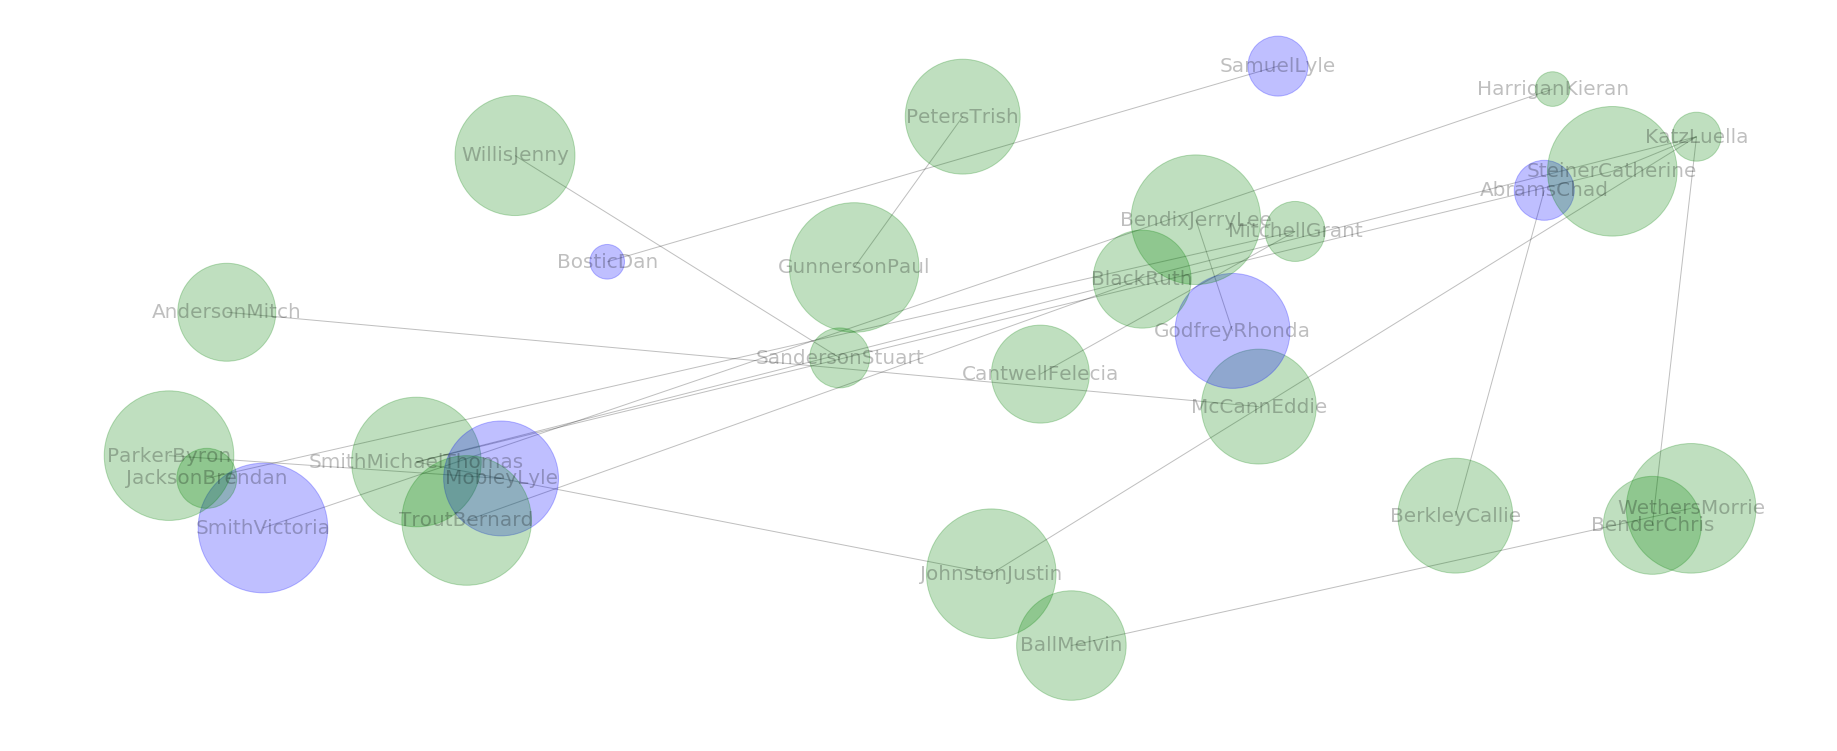

In [26]:
luella_katz = nx.ego_graph(PC, 'KatzLuella', radius=1, center=True, undirected=True, distance='weight')

nodecolors=[]
for n in dict(pc.degree(top_nodes)).keys():
    if n in suspects:
        nodecolors.append('g')
    elif n in victims:
        nodecolors.append('b')
    else:
        nodecolors.append('y')

dkatz = luella_katz.degree()
nx.draw_random(pc, node_size=[v*1200 for v in dict(dkatz).values()], with_labels=True, node_color=nodecolors, 
               alpha=.25, font_size=20)


In [27]:
luella_katz = extended_crime[extended_crime['Person']=='KatzLuella']
katz_connections = pd.DataFrame(cc.edges('KatzLuella'))
katz_con = set(katz_connections.iloc[:,1])
a = len(katz_con.intersection(victims))
b = len(katz_con.intersection(suspects))

print ('Luella Katz:')
print ('***************************')
print ('Victim connections:  ', a)
print ('Suspect connections: ', b)



Luella Katz:
***************************
Victim connections:   22
Suspect connections:  40


## Crimes - Bipartite Projection

#### Let's now take the set of Crime nodes and the relation between them based on the same person.

In [28]:
CC = nx.bipartite.weighted_projected_graph(G2, bottom_nodes)

#### 1. Crimes - island Analysis

The island analysis identifies a six-node network of crimes. Examination of the crimes shows they all involved Luella Katz and close associates who were suspects. Katz was a witness in crime 110 along with 14 other individuals.

In [29]:
## Run the Island Analysis on the graph
islands = island_method(CC, iterations = 2)

print ('Depth  Crime  Networks')
print ('************************')
for island in islands:
    print(' %d      %3d      %2d' 
          %(island[0], len(island[1]), len(list(nx.connected_component_subgraphs(island[1])))))
    

Depth  Crime  Networks
************************
 1      119      36
 2       10       3


#### 2. Graph This!!

C:\Users\moc9029\AppData\Roaming\Python\Python37\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


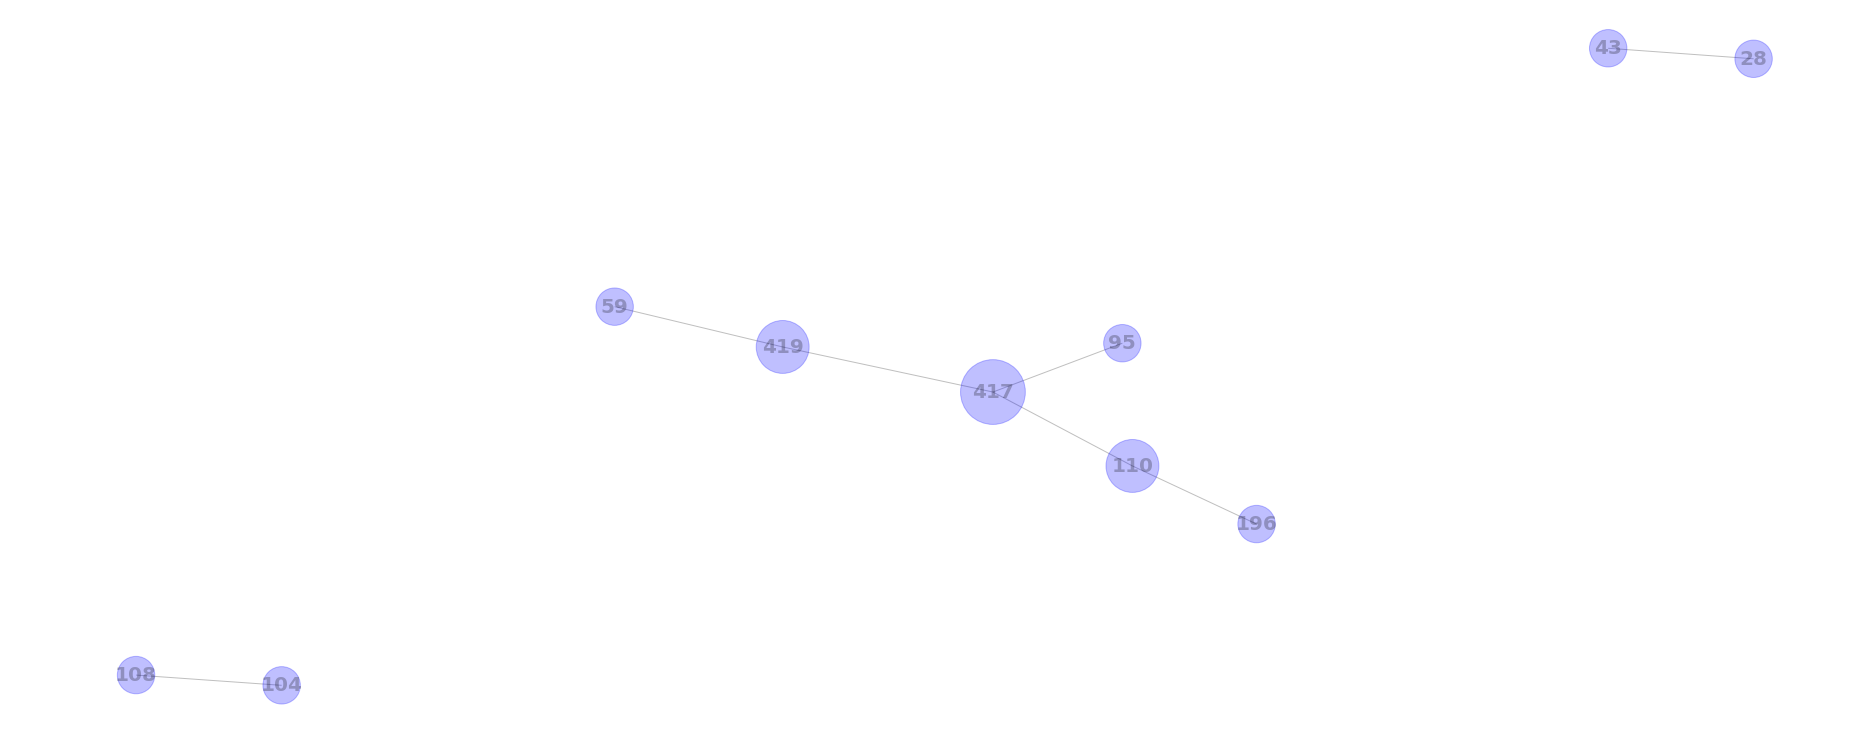

In [30]:
# 2 graphs created by the island analysis:
wc = trim_edges(CC, 2)
dwc = wc.degree()
nx.draw(wc, node_size=[v*1400 for v in dict(dwc).values()], with_labels=True, node_color='b', alpha=.25, font_weight='bold', font_size=20)


## Centrality Measures

In the table below we take the bipartite weighted graph and examine centrality measures. Per our visual analysis, Luella Katz's heavy involvement is confirmed; she ranks among the top 10 three centrality categories. Katz, Cathering Steiner and Michael Smith all are among the highest in eigenvector centrality – in other words, they are connected to other highly connected suspects and victims. Jenny Willis ranks high in betweenness and degree centrality. A plot of her ego network is below. Inspection shows that Willis and Katz were not involved in any of the same crimes.

Crime 110 is of note for high betweeeness centrality: The crime involved 15 witnesses, 2 suspects and one victim.


In [33]:
## utility function to get topmost nodes for each centrality function
def get_top_keys(c, top):
    items = c.items()
    items.sort(reverse=True, key=lambda d:d[1])
    return map(lambda x: x, items[:top])

# Betweenness centrality
bet_cen = nx.betweenness_centrality(G2)

# Degree centrality
deg_cen = nx.degree_centrality(G2)

# Closeness centrality
clo_cen = nx.closeness_centrality(G2)

# Eigenvector centrality
eig_cen = nx.eigenvector_centrality_numpy(G2)

